# Pokémon automatic identification using CNN and Transfer Learning
## For a Pokedex
### Developed by Eduardo Weide Luiz

# Resizing Images
### Takes an image database and resize them to 128x128 pixel

In [2]:
import os
from PIL import Image

# Base directory containing folders with images
base_dir = '/Volumes/Elements/pokemon'

# New base directory where the resized images will be saved
new_base_dir = '/Users/eduardowluiz/Documents/Pokemon_imgs'

# Target size for images
target_size = (128, 128)

# Supported image formats
supported_formats = ('.jpg', '.jpeg', '.png', '.gif', '.bmp')

# Iterate through each folder and process the images
for root, dirs, files in os.walk(base_dir):
    # Get the relative path of the current folder with respect to the base directory
    relative_path = os.path.relpath(root, base_dir)
    
    # Construct the corresponding folder path in the new directory
    new_folder_path = os.path.join(new_base_dir, relative_path)
    
    # Create the new folder path if it doesn't exist
    os.makedirs(new_folder_path, exist_ok=True)
    
    folder_name = os.path.basename(root)
    counter = 1
    
    for file in files:
        if file.lower().endswith(supported_formats):
            # Construct full file path
            file_path = os.path.join(root, file)
            
            # Open and resize image
            with Image.open(file_path) as img:
                img_resized = img.resize(target_size)
                
                # Convert 'RGBA', 'P', or 'LA' to 'RGB' or 'L' if needed
                if img_resized.mode == 'RGBA' or img_resized.mode == 'P':
                    img_resized = img_resized.convert('RGB')
                elif img_resized.mode == 'LA':
                    img_resized = img_resized.convert('L')
                
                # Create the new file name
                new_file_name = f"{folder_name}_{counter:03d}.jpg"
                new_file_path = os.path.join(new_folder_path, new_file_name)
                
                # Save the resized image in the new directory
                img_resized.save(new_file_path)
                
                # Increment counter
                counter += 1

print("Image resizing and saving completed!")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Image resizing and saving completed!


# Images pre-processing
### Data augmentation and Train-Validation Split

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Directory where images are stored
data_dir = '/Users/eduardowluiz/Documents/Pokemon_imgs'

# Image dimensions and batch size
img_height = 128
img_width = 128
batch_size = 32

# Data augmentation and normalization for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values
    validation_split=0.20,      # 20% split of the original dataset: 20% for validation
    horizontal_flip=True,      # Optional: Horizontal flip for augmentation
    rotation_range=10,         # Optional: Random rotation for augmentation
)

# Training data: 80% of the data
train_dataset = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # One-hot encoded labels
    subset='training',          # Use subset for training
    seed=42                    # Set seed for reproducibility
)

# Validation data: 20% of the data
validation_dataset = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # One-hot encoded labels
    subset='validation',       # Use subset for validation
    seed=42                    # Set seed for reproducibility
)


# Print the number of samples in each dataset
print(f"Training samples: {train_dataset.samples}")
print(f"Validation samples: {validation_dataset.samples}")

Found 13861 images belonging to 143 classes.
Found 3400 images belonging to 143 classes.
Training samples: 13861
Validation samples: 3400


# Training the CNN Model
## Transfer learning from the base model MobileNetV2


In [13]:
import keras
# Unfreeze the last few layers of the base model
base_model.trainable = True

# Optionally, freeze all layers except the last few
for layer in base_model.layers[:-30]:  # Unfreeze the last 30 layers
    layer.trainable = False

# Compile the model again with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,  # Fine-tune for a few more epochs
)


Epoch 1/10
434/434 ━━━━━━━━━━━━━━━━━━━━ 87s 193ms/step - accuracy: 0.8304 - loss: 0.6303 - val_accuracy: 0.9182 - val_loss: 0.3326
Epoch 2/10
434/434 ━━━━━━━━━━━━━━━━━━━━ 88s 202ms/step - accuracy: 0.8338 - loss: 0.6252 - val_accuracy: 0.9191 - val_loss: 0.3193
Epoch 3/10
434/434 ━━━━━━━━━━━━━━━━━━━━ 88s 201ms/step - accuracy: 0.8414 - loss: 0.5861 - val_accuracy: 0.9215 - val_loss: 0.3139
Epoch 4/10
434/434 ━━━━━━━━━━━━━━━━━━━━ 95s 217ms/step - accuracy: 0.8492 - loss: 0.5650 - val_accuracy: 0.9235 - val_loss: 0.3148
Epoch 5/10
434/434 ━━━━━━━━━━━━━━━━━━━━ 90s 206ms/step - accuracy: 0.8545 - loss: 0.5367 - val_accuracy: 0.9238 - val_loss: 0.3090
Epoch 6/10
434/434 ━━━━━━━━━━━━━━━━━━━━ 102s 234ms/step - accuracy: 0.8584 - loss: 0.5423 - val_accuracy: 0.9226 - val_loss: 0.3106
Epoch 7/10
434/434 ━━━━━━━━━━━━━━━━━━━━ 98s 225ms/step - accuracy: 0.8599 - loss: 0.5248 - val_accuracy: 0.9232 - val_loss: 0.3071
Epoch 8/10
434/434 ━━━━━━━━━━━━━━━━━━━━ 102s 232ms/step - accuracy: 0.8655 - loss:

# Saving the model

In [14]:
# Save the fine-tuned model
keras.saving.save_model(model, 'pokemon_cnn_finetuned_model.keras')

# Test the model using a different image

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted label: Charmander


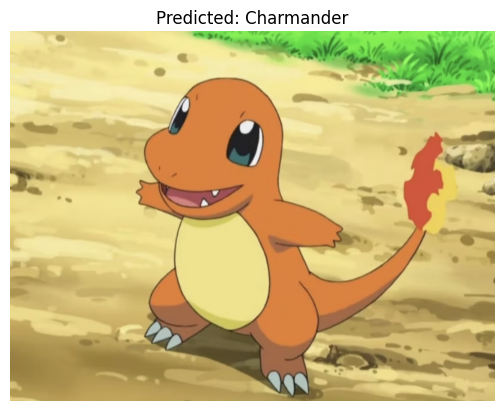

In [5]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('pokemon_cnn_finetuned_model.keras')

# Function to load and preprocess the image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))  # Resize the image to 128x128
    img_array = image.img_to_array(img)  # Convert the image to an array
    img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension
    img_array /= 255.0  # Normalize the image (scale pixel values to [0, 1])
    return img_array

# Function to predict the class of an image
def predict_image(img_path, model):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)  # Make predictions
    predicted_class = np.argmax(predictions, axis=1)[0]  # Get the index of the predicted class

    # Map class indices to class labels
    class_indices = {v: k for k, v in train_dataset.class_indices.items()}  # Invert the class_indices dictionary
    predicted_label = class_indices[predicted_class]  # Get the label for the predicted class

    return predicted_label, predictions[0]

# Provide the path to the new image
new_image_path = '/Users/eduardowluiz/Documents/Pokémons/pkm.png'  # Update with your image path

# Get the prediction
predicted_label, predictions = predict_image(new_image_path, model)

# Display the result
print(f"Predicted label: {predicted_label}")

# Display the image
img = image.load_img(new_image_path)
plt.imshow(img)
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()


# Save the class indices to a json file

In [ ]:
import json

# Assuming train_dataset is your training data generator or dataset
class_indices = train_dataset.class_indices

# Save class indices to a JSON file
with open('class_indices.json', 'w') as f:
    json.dump(class_indices, f)